# Modelo supervisado de auditoría de prestaciones médicas extrahospitalarias  
**Proyecto:** ML Auditoría de Prestaciones Médicas Extrahospitalarias - Provincia de Tierra del Fuego

**Autora:** Nancy Julieta Cassano

**Docente:** Nicolás Caballero

**Materia:** Aprendizaje Automático

**Año:** 2025  
  

## 1. Objetivo del notebook
Implementar y evaluar modelos de clasificación supervisada para predecir si una solicitud de prestación médica debe ser autorizada o no, usando el dataset sintético homologado.

## 2. Flujo de trabajo
1. Carga del dataset procesado.  
2. Separación de variable objetivo y predictoras.  
3. División train/test con estratificación.  
4. Entrenamiento de modelo base (DummyClassifier).  
5. Entrenamiento de modelos supervisados (Regresión Logística, Árbol de Decisión).  
6. Evaluación y comparación de métricas.



In [1]:
# BLOQUE 1: importación de librerías básicas

import pandas as pd

# para separar en train y test
from sklearn.model_selection import train_test_split

# modelo base "Dummy"
from sklearn.dummy import DummyClassifier

# métricas para evaluar
from sklearn.metrics import classification_report, confusion_matrix


En este BLOQUE 1 se importan las librerías esenciales para el modelado supervisado.

-`pandas` se utiliza para manejar los datos en forma de tablas,

-`train_test_split` permite dividir los datos en entrenamiento y prueba,

-`DummyClassifier` crea un modelo de referencia sin aprendizaje real, y

-las funciones de `sklearn.metrics` sirven para calcular las métricas de desempeño del modelo.


In [2]:
# BLOQUE 2: carga del dataset procesado/homologado

import pandas as pd

ruta = "/content/dataset_prestaciones_extrahospitalarias_2025_realista_v1_homologado.csv"
df = pd.read_csv(ruta)
df.head(), df.shape






(     expediente_id fecha_solicitud   zona hospital_origen  edad  estado_civil  \
 0  SOL-2025-000001      2025-04-13    sur    CAPS_Tolhuin    50     soltero/a   
 1  SOL-2025-000002      2025-09-28  norte    CAPS_Ushuaia    44      casado/a   
 2  SOL-2025-000003      2025-04-17     sr  CAPS_RioGrande    54      casado/a   
 3  SOL-2025-000004      2025-03-13  norte             HRU    22  divorciado/a   
 4  SOL-2025-000005      2025-07-08    sur    CAPS_Ushuaia    36           NaN   
 
   dni_domicilio_tdf disponibilidad_publica cobertura_activa  \
 0                 1                      1                1   
 1                 1                      1                0   
 2                 1                      0                0   
 3                 1                      1                1   
 4                 1                      0                0   
 
   verificacion_no_cobertura  ... cud   vivienda  vehiculos  \
 0                         S  ...   0     cedida        2

En el BLOQUE 2, se carga el dataset previamente homologado y depurado en el notebook correspondiente.  
Cada fila representa una solicitud de prestación médica extrahospitalaria, y cada columna corresponde a una característica relevante (zona, edad, cobertura, informe social, etc.).  
La vista previa confirma que los datos se leen correctamente y que la estructura general coincide con el archivo validado.


In [3]:
# BLOQUE 3: inspección rápida de columnas y tipos de datos

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   expediente_id               1200 non-null   object 
 1   fecha_solicitud             1200 non-null   object 
 2   zona                        1200 non-null   object 
 3   hospital_origen             1200 non-null   object 
 4   edad                        1200 non-null   int64  
 5   estado_civil                1116 non-null   object 
 6   dni_domicilio_tdf           1193 non-null   object 
 7   disponibilidad_publica      1189 non-null   object 
 8   cobertura_activa            1192 non-null   object 
 9   verificacion_no_cobertura   1193 non-null   object 
 10  derecho_cobertura           1194 non-null   object 
 11  grupo_familiar              1200 non-null   int64  
 12  ingresos_mensuales_ars      1116 non-null   float64
 13  egresos_mensuales_ars       1116 

En el BLOQUE 3, la función `df.info()` muestra el número de filas (1.200) y las 25 columnas disponibles.  
Se observa una combinación de variables numéricas (`int64`, `float64`) y categóricas (`object`).  
También se identifican algunos valores faltantes (por ejemplo en `estado_civil` o `ingresos_mensuales_ars`), que serán tratados en la etapa de preprocesamiento posterior si fuera necesario.  
Este análisis permite anticipar qué columnas requieren codificación o limpieza antes del modelado.


In [4]:
# BLOQUE 4: separar variable objetivo y variables predictoras

# 1. variable objetivo
y = df["autorizado"]

# 2. variables que NO quiero usar como entrada del modelo
columnas_a_excluir = [
    "autorizado",          # el target
    "expediente_id",       # identificador, no sirve para aprendizaje
    "motivo_no_autorizacion",  # tiene info del futuro
    "fecha_solicitud" if "fecha_solicitud" in df.columns else None # para no romper si esa columna no existe en el CSV
]

# limpiar la lista por si alguna no existe
columnas_a_excluir = [c for c in columnas_a_excluir if c in df.columns]

# 3. el resto son mis features
X = df.drop(columns=columnas_a_excluir)
X.head()


,zona,hospital_origen,edad,estado_civil,dni_domicilio_tdf,disponibilidad_publica,cobertura_activa,verificacion_no_cobertura,derecho_cobertura,grupo_familiar,...,egresos_mensuales_ars,ocupacion,cud,vivienda,vehiculos,informe_social_presente,documentacion_completa,informe_medico_adjunto,costo_estimado_ars,ingreso_neto_percapita_ars
0,sur,CAPS_Tolhuin,50,soltero/a,1,1,1,S,0,0,...,NaN,rel_depend,0,cedida,2.0,0,0,NaN,NaN,NaN
1,norte,CAPS_Ushuaia,44,casado/a,1,1,0,0,0,0,...,499045.97,informal,0,propia,1.0,1,1,NaN,NaN,NaN
2,sr,CAPS_RioGrande,54,casado/a,1,0,0,0,0,2,...,526301.37,desocupado,1,propia,0.0,1,1,NaN,NaN,NaN
3,norte,HRU,22,divorciado/a,1,1,1,0,0,2,...,112221.27,monotributo,1,alquilada,0.0,1,1,NaN,NaN,NaN
4,sur,CAPS_Ushuaia,36,NaN,1,0,0,0,0,1,...,1288777.81,rel_depend,1,propia,0.0,1,1,NaN,NaN,NaN


En el BLOQUE 4 se define la variable objetivo (`autorizado`), que toma valores binarios:  
1 = prestación autorizada, 0 = no autorizada.  

Se excluyen del conjunto de entrenamiento las columnas que no aportan información predictiva o que introducirían sesgo:  
- `expediente_id` (identificador único),  
- `motivo_no_autorizacion` (información del futuro),  
- `fecha_solicitud` (no aporta a la decisión).  

El conjunto `X` contiene así las 21 variables predictoras que describen cada solicitud.  
Este paso es clave para asegurar que el modelo aprenda solo a partir de la información disponible al momento de la evaluación real.


In [5]:
# BLOQUE 5: train-test split con estratificación

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,      # 70% entreno, 30% pruebo
    random_state=42,    # para que siempre dé igual
    stratify=y          # mantiene proporciones de 0 y 1
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((840, 21), (360, 21), (840,), (360,))

En el BLOQUE 5 se dividen los datos en dos subconjuntos:  
- **70 % entrenamiento** (`X_train`, `y_train`)  
- **30 % prueba** (`X_test`, `y_test`)  

El parámetro `stratify=y` garantiza que la proporción entre solicitudes autorizadas y no autorizadas se mantenga igual en ambos subconjuntos.  
Esto evita que el modelo se entrene o evalúe sobre datos desequilibrados.  
La forma final muestra 840 registros de entrenamiento y 360 de prueba, manteniendo la estructura original.


In [6]:
# BLOQUE 6: modelo base para referencia (no aprende nada, sólo dice “lo que más aparece”, imprime las métricas)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

print("=== Modelo base (DummyClassifier) ===")
print(classification_report(y_test, y_pred_dummy))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_dummy))


=== Modelo base (DummyClassifier) ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.91      1.00      0.95       328

    accuracy                           0.91       360
   macro avg       0.46      0.50      0.48       360
weighted avg       0.83      0.91      0.87       360

Matriz de confusión:
 [[  0  32]
 [  0 328]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


En el BLOQUE 6, el `DummyClassifier` establece una línea de referencia o “piso” de rendimiento.  
En este caso, la estrategia **`most_frequent`** predice siempre la clase mayoritaria (**autorizada = 1**).

**Resultados principales:**
- **Accuracy:** `0.91`, representa el 91 % de aciertos totales, pero sólo por el predominio de una clase.  
- **Precision/Recall (clase 0):** `0`, porque el modelo nunca predice correctamente los casos no autorizados.  
- **Precision/Recall (clase 1):** muy altos (cercanos a 1.0), porque únicamente predice esa clase.  
- **Matriz de confusión:** `[[0, 32], [0, 328]]`, confirma que todos los casos fueron clasificados como “autorizados”.  
Los **32 casos no autorizados** fueron clasificados como “autorizados” (**falsos negativos**), mientras que los **328 autorizados** fueron correctamente clasificados (**verdaderos positivos**).  

Este modelo no tiene capacidad predictiva real: simplemente repite el patrón mayoritario.  
Sin embargo, cumple un papel importante como **modelo base de comparación**, a partir del cual se evaluará la mejora obtenida con los modelos verdaderos (**Regresión Logística**, **Árbol de Decisión**, etc.).

Nota sobre la advertencia:
El mensaje UndefinedMetricWarning aparece porque el modelo DummyClassifier nunca predijo la clase 0 (“no autorizado”), por lo tanto, no hay ejemplos positivos para calcular la precisión de esa clase.
Scikit-learn asigna automáticamente el valor 0 y continúa la ejecución sin afectar el resto de las métricas.
Esta advertencia es esperable y no representa un error, ya que confirma que el modelo solo repite la clase mayoritaria.

In [7]:
# BLOQUE 7: Modelo de Regresión Logística

# 7.1: imports para el modelo

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix


En este BLOQUE 7.1 se importan las clases necesarias para construir el modelo de clasificación:

- `LogisticRegression`: será el modelo supervisado que aprenderá las relaciones entre las variables.
- `OneHotEncoder` y `ColumnTransformer`: permiten transformar las variables categóricas a formato numérico.
- `Pipeline`: combina el preprocesamiento con el modelo, asegurando que todo el flujo de trabajo se ejecute de forma ordenada y reproducible.



In [8]:
# 7.2: identificar columnas categóricas y numéricas

cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(exclude=['object']).columns

cat_features, num_features


(Index(['zona', 'hospital_origen', 'estado_civil', 'dni_domicilio_tdf',
        'disponibilidad_publica', 'cobertura_activa',
        'verificacion_no_cobertura', 'derecho_cobertura', 'ocupacion', 'cud',
        'vivienda', 'informe_social_presente', 'documentacion_completa'],
       dtype='object'),
 Index(['edad', 'grupo_familiar', 'ingresos_mensuales_ars',
        'egresos_mensuales_ars', 'vehiculos', 'informe_medico_adjunto',
        'costo_estimado_ars', 'ingreso_neto_percapita_ars'],
       dtype='object'))

En el BLOQUE 7.2 se identifican las columnas categóricas y numéricas del dataset:

- `cat_features`: contiene las variables de tipo texto (`object`), que requerirán codificación.
- `num_features`: incluye las variables numéricas, que pueden utilizarse directamente en el modelo.

Este paso permite aplicar diferentes transformaciones según el tipo de variable, esencial en los modelos de aprendizaje supervisado.


In [9]:
# 7.3: preprocesamiento de datos

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)


En este BLOQUE 7.3 se define el `ColumnTransformer`, que aplica distintas transformaciones a los dos grupos de variables:

- A las **categóricas**, se les aplica `OneHotEncoder`, que las convierte en variables binarias (0/1) para que el modelo pueda interpretarlas.
- A las **numéricas**, se les aplica `'passthrough'`, lo que significa que pasan directamente sin ser modificadas.

Este preprocesamiento asegura que todas las variables estén en formato numérico y que el modelo pueda procesarlas correctamente.


In [10]:
# 7.4: definir el modelo de clasificación

log_reg = LogisticRegression(max_iter=1000, random_state=42)


En este paso se define el modelo de **Regresión Logística**, que será utilizado para predecir la probabilidad de que una solicitud de prestación sea **autorizada (1)** o **no autorizada (0)**.  
Se trata de un modelo supervisado de clasificación binaria, elegido por su capacidad para ofrecer **predicciones interpretables** y **coeficientes explicativos**, lo cual es fundamental en entornos institucionales donde las decisiones deben poder justificarse.

El parámetro `max_iter=1000` permite que el algoritmo realice suficientes iteraciones para asegurar la convergencia del modelo,
y `random_state=42` garantiza la reproducibilidad de los resultados.  

Este modelo servirá como base para comparar posteriormente su desempeño con el Árbol de Decisión, evaluando cuál ofrece mejor equilibrio entre precisión y capacidad explicativa.


In [12]:
# 7.5: pipeline = preprocesamiento + modelo --- (intento 1) – entrenamiento sin imputación

model_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

# entrenar
model_log.fit(X_train, y_train)


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

**Nota sobre este intento de entrenamiento:**

El primer intento de entrenar el modelo de Regresión Logística falló con el error:

`ValueError: Input X contains NaN. LogisticRegression does not accept missing values encoded as NaN natively.`

Esto significa que en el conjunto de entrenamiento (`X_train`) había valores faltantes (NaN) en alguna de las columnas, y este modelo no puede trabajar con datos incompletos.

Para resolverlo, en el bloque siguiente (7.4 bis), agregué una etapa de imputación (`SimpleImputer`) dentro del preprocesador. Esa imputación completa los valores faltantes antes de entrenar, y luego el modelo se puede ajustar sin problemas.


In [13]:
# 7.4bis: manejo de valores faltantes

from sklearn.impute import SimpleImputer

# imputadores: reemplazan NaN por valores razonables según tipo de variable
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

# nuevo preprocessor con imputación + codificación
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline(steps=[
            ('imputer', cat_imputer),
            ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
        ]), cat_features),
        ('num', Pipeline(steps=[
            ('imputer', num_imputer)
        ]), num_features)
    ]
)


Qué hace este BLOQUE 7.4 bis:

- `SimpleImputer` rellena los valores faltantes:

-En columnas numéricas con la mediana.

-En columnas categóricas con el valor más frecuente.

- Se arma un nuevo preprocessor que:

-primero imputa los datos,

-luego aplica el OneHotEncoder para variables categóricas,

-y deja pasar las numéricas ya imputadas.

In [14]:
# 7.5: pipeline = preprocesamiento + modelo

model_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

# entrenar
model_log.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['zona', 'hospital_origen', 'estado_civil', 'dni_domicilio_tdf',
       'disponibilidad_publica', 'cobertura_activa',
       'verificacion_no_cobertura', 'derec...
       'vivienda', 'informe_social_presente', 'documentacion_completa'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['edad', 'grupo_familiar', 'ingresos_mensuales_ars',
       'egresos_mensuales_ars', 'vehiculos', 'informe_medico_adjunto',
       'costo_estimado_ars', 'ingreso_neto_percapita_ars'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

En este BLOQUE 7.5 se construye y ejecuta el `Pipeline` que combina el preprocesamiento de datos con el modelo de clasificación.

1. **Pipeline:**  
   Se definen dos pasos principales:

   -`'preprocessor'`: contiene todas las transformaciones previas (imputación y codificación) definidas en bloques anteriores.
   
   -`'classifier'`: corresponde al modelo de **Regresión Logística**, que será el encargado de aprender los patrones de autorización.

2. **Entrenamiento (`fit`)**:  
   El comando `model_log.fit(X_train, y_train)` entrena el modelo usando el conjunto de entrenamiento.  
   Durante este proceso, el pipeline:

   -Rellena los valores faltantes (`SimpleImputer`)

   -Codifica las variables categóricas (`OneHotEncoder`)

   -Ajusta los coeficientes del modelo de Regresión Logística para minimizar el error.

3. **Advertencia (Warning):**  
   El mensaje indica que algunas variables (como `'informe_medico_adjunto'`, `'costo_estimado_ars'` e `'ingreso_neto_percapita_ars'`) no tenían valores observados válidos para calcular la mediana.  
   No es un error, sólo una advertencia: `SimpleImputer` ignora esas columnas vacías y continúa el entrenamiento con las demás.

4. **Visualización del Pipeline:**  
   El esquema que se genera muestra claramente la estructura del flujo de trabajo. Este diagrama confirma que el proceso completo de imputación, codificación y modelado quedó correctamente encadenado.




In [15]:
# 7.6: Evaluación del modelo de Regresión Logística

y_pred_log = model_log.predict(X_test)

print("Modelo de Regresión Logística")
print(classification_report(y_test, y_pred_log))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_log))


Modelo de Regresión Logística
              precision    recall  f1-score   support

           0       0.70      0.22      0.33        32
           1       0.93      0.99      0.96       328

    accuracy                           0.92       360
   macro avg       0.81      0.60      0.65       360
weighted avg       0.91      0.92      0.90       360

Matriz de confusión:
 [[  7  25]
 [  3 325]]


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


En este BLOQUE 7.6 se evalúa el rendimiento del modelo de **Regresión Logística** utilizando el conjunto de prueba (`X_test`, `y_test`).

1. **Predicción:**  
   El comando `y_pred_log = model_log.predict(X_test)` genera las predicciones del modelo ya entrenado sobre datos nuevos que no habían sido utilizados durante el entrenamiento.  
   Esto permite medir su capacidad de generalización.

2. **Métricas de evaluación:**  
   El informe generado por `classification_report()` resume las principales medidas de desempeño del modelo.  
   Se observa que para la clase **0 (no autorizado)** la precisión es de 0.70, el recall de 0.22 y el f1-score de 0.33, mientras que para la clase **1 (autorizado)** la precisión alcanza 0.93, el recall 0.99 y el f1-score 0.96.  

   En conjunto, la **exactitud global (accuracy)** es de 0.92, lo que indica que el modelo acierta el 92 % de las predicciones totales.  
   Sin embargo, la recuperación de los casos no autorizados es baja (22 %), lo cual sugiere que el modelo tiende a favorecer la clase mayoritaria.  
   Las métricas ponderadas (**weighted average**) mantienen valores altos, reflejando que el modelo tiene un buen rendimiento general a pesar del desbalance de clases.

3. **Matriz de confusión:**  
   La matriz resultante muestra la siguiente distribución:

   * 7 verdaderos negativos (casos no autorizados correctamente detectados)

   * 25 falsos positivos (casos no autorizados que el modelo clasificó erróneamente como autorizados)

   * 3 falsos negativos (casos autorizados que fueron clasificados como no autorizados)

   * 325 verdaderos positivos (autorizados correctamente clasificados).  

   Esto evidencia que el modelo logra un excelente desempeño en la detección de solicitudes autorizadas, aunque aún presenta limitaciones en la identificación de los casos rechazados.

4. **Interpretación general:**  
   La **Regresión Logística** logra un desempeño alto y estable.  
   Es un modelo que, aunque todavía se ve influenciado por el desbalance entre clases, **supera ampliamente al modelo base (DummyClassifier)** y demuestra una capacidad real de aprendizaje.  
   Representa un punto de partida sólido para futuras mejoras, como el ajuste de umbrales o el uso de técnicas de balanceo.


Aclaración sobre la advertencia (UserWarning):
El mensaje que aparece debajo de la matriz de confusión indica que algunas variables (por ejemplo, 'informe_medico_adjunto', 'costo_estimado_ars' o 'ingreso_neto_percapita_ars') no tenían valores válidos para calcular la mediana durante la imputación.
Por eso, el SimpleImputer(strategy='median') saltea automáticamente esas columnas y continúa el entrenamiento con las demás.
No afecta el funcionamiento del modelo ni los resultados obtenidos, ya que esas variables no aportaban información útil al aprendizaje.

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


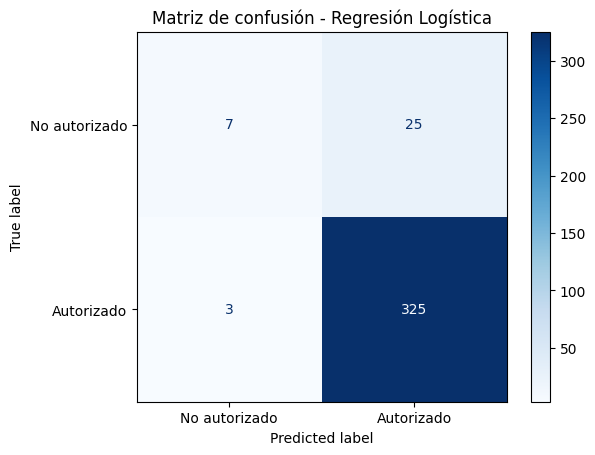

In [31]:
# 7.7 - Matriz de confusión - Visual

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predicciones
y_pred_log = model_log.predict(X_test)

# matriz
cm_log = confusion_matrix(y_test, y_pred_log)

# gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=['No autorizado', 'Autorizado'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - Regresión Logística")
plt.show()


BLOQUE 7.7

La matriz de confusión muestra que el modelo de Regresión Logística clasifica correctamente la gran mayoría de los casos **autorizados** (325 verdaderos positivos) y comete muy pocos errores de este tipo (3 falsos negativos).

Sin embargo, es más difícil de detectar la clase minoritaria (**no autorizado**): de 32 casos reales no autorizados, solo 7 fueron detectados correctamente y 25 fueron predichos como autorizados. Esto se explica por el desbalance del conjunto de datos, donde la clase “autorizado” es claramente mayoritaria.

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


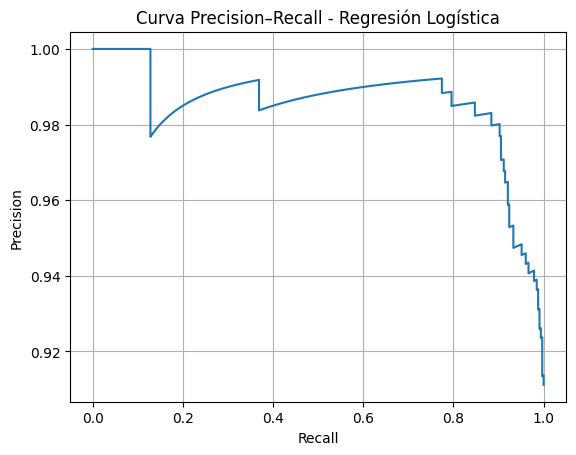

In [32]:
# 7.8: Curva Precision–Recall - Regresión Logística

from sklearn.metrics import precision_recall_curve

y_scores_log = model_log.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores_log)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - Regresión Logística")
plt.grid(True)
plt.show()


BLOQUE 7.8

La curva Precision-Recall del modelo logístico se mantiene en valores altos de precisión incluso cuando aumenta el recall. Esto indica que el modelo es capaz de recuperar una proporción importante de los casos autorizados sin degradar demasiado la precisión.

Dado que el problema trabaja con clases desbalanceadas, esta curva es más informativa que la accuracy sola. En un contexto de auditoría, esta performance es adecuada porque permite recuperar la mayoría de las solicitudes que deben autorizarse, y el umbral de decisión podría ajustarse para ser más estricto si se quisiera reducir aún más los falsos positivos.


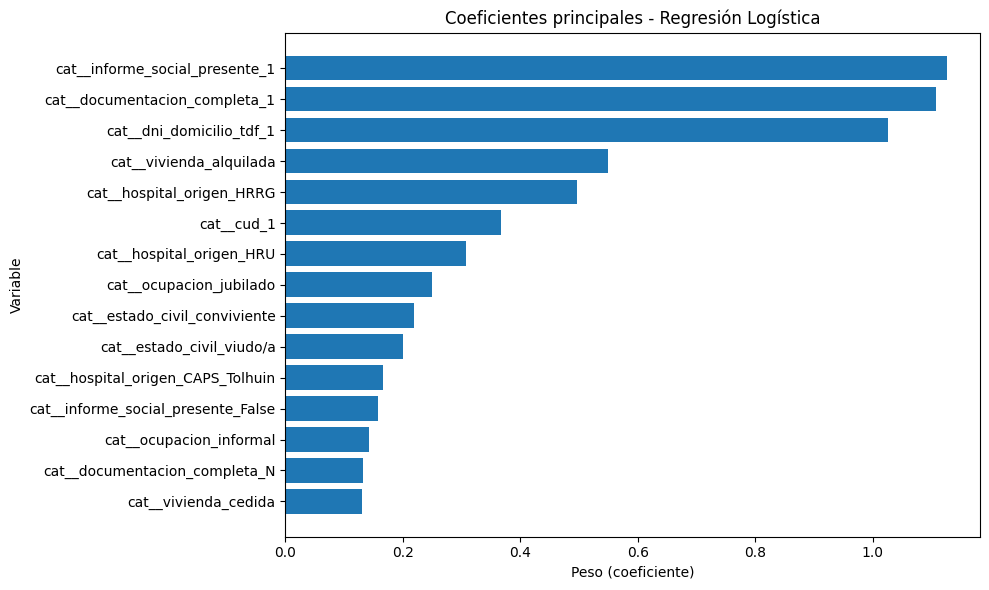

In [33]:
# 7.9: Coeficientes principales - Regresión Logística

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

coef = model_log.named_steps['classifier'].coef_[0]
feature_names = model_log.named_steps['preprocessor'].get_feature_names_out()

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coeficiente': coef
}).sort_values(by='Coeficiente', ascending=False)

# Gráfico de las variables más influyentes
plt.figure(figsize=(10,6))
plt.barh(coef_df['Variable'][:15], coef_df['Coeficiente'][:15])
plt.title("Coeficientes principales - Regresión Logística")
plt.xlabel("Peso (coeficiente)")
plt.ylabel("Variable")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


BLOQUE 7.9

En el gráfico se observan las variables que más peso tuvieron en la Regresión Logística luego del preprocesamiento (one-hot encoding). Los coeficientes positivos aumentan la probabilidad de que el caso sea clasificado como **autorizado**, mientras que los coeficientes negativos la reducen.

Se destacan variables coherentes con el circuito administrativo, como la presencia del informe social, la documentación completa y el domicilio dentro de la provincia. Esto es importante porque muestra que el modelo no está tomando decisiones arbitrarias sino que está utilizando la misma información que usa el área de prestaciones para evaluar los pedidos.

Este tipo de explicación es una ventaja de la Regresión Logística frente a otros modelos: permite justificar por qué una solicitud fue clasificada de determinada manera.


In [16]:
# BLOQUE 8: Modelo de Árbol de Decisión

# 8.1: imports para Árbol de Decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

**BLOQUE 8.1 - Imports para Árbol de Decisión**

En este bloque se importan las librerías necesarias para construir el modelo de **Árbol de Decisión**:

- `DecisionTreeClassifier`: permite crear el clasificador basado en reglas jerárquicas.
- `classification_report` y `confusion_matrix`: se utilizan para evaluar las métricas de desempeño.
- `Pipeline`: permite encadenar en una sola estructura el preprocesamiento y el modelo, garantizando que los pasos se apliquen en el orden correcto.

El objetivo de este bloque es preparar el entorno para reutilizar el mismo flujo de datos que en la **Regresión Logística**, cambiando únicamente el algoritmo de clasificación.


In [17]:
# 8.2: definición del clasificador de árbol
tree_clf = DecisionTreeClassifier(
    max_depth=5,        # limito la profundidad a 5
    random_state=42,    # reproducible
    class_weight=None   # por ahora sin ponderación
)


**BLOQUE 8.2 - Definición del clasificador de árbol**

En este bloque se define la configuración del modelo **DecisionTreeClassifier**, indicando los parámetros principales:

- `max_depth=5`: limita la profundidad del árbol para evitar el sobreajuste (*overfitting*), permitiendo un modelo más generalizable.
- `random_state=42`: fija una semilla aleatoria para que los resultados sean reproducibles en cada ejecución.
- `class_weight=None`: mantiene las clases sin ponderación, es decir, el modelo se entrena considerando el desbalance natural del dataset.

Con esto se crea una instancia del clasificador, lista para incorporarse a la pipeline.


In [18]:
# 8.3: pipeline = preprocesamiento + árbol
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),  # el que ya tenía con imputación + OHE
    ('classifier', tree_clf)
])


**BLOQUE 8.3 - Pipeline = preprocesamiento + árbol**

En este bloque se crea una **Pipeline** que combina el preprocesamiento de datos (imputación y codificación) con el modelo de **Árbol de Decisión**.

- `'preprocessor'`: reutiliza el mismo objeto creado anteriormente, que aplica `SimpleImputer` para completar valores faltantes y `OneHotEncoder` para convertir las variables categóricas.
- `'classifier'`: corresponde al árbol definido en el bloque anterior (`tree_clf`).

El código '**model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', tree_clf)
])**' permite que el árbol reciba siempre los datos ya transformados, garantizando coherencia entre entrenamiento y predicción, y posibilitando una comparación justa con la Regresión Logística.

In [19]:
# 8.4: entrenar el árbol
model_tree.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['zona', 'hospital_origen', 'estado_civil', 'dni_domicilio_tdf',
       'disponibilidad_publica', 'cobertura_activa',
       'verificacion_no_cobertura', 'derec...
       'vivienda', 'informe_social_presente', 'documentacion_completa'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['edad', 'grupo_familiar', 'ingresos_mensuales_ars',
       'egresos_mensuales_ars', 'vehiculos', 'informe_medico_adjunto',
       'costo_estimado_ars', 'ingreso_neto_percapita_ars'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

**BLOQUE 8.4 - Entrenamiento del árbol**

En este bloque se entrena el modelo de **Árbol de Decisión** dentro de la pipeline que ya incluye imputación y codificación.

El comando '**model_tree.fit(X_train, y_train)**' ejecuta las siguientes etapas en secuencia:

**1.** Rellena los valores faltantes (SimpleImputer) en variables numéricas y categóricas.

**2.** Aplica el OneHotEncoder para transformar las variables categóricas.

**3.** Ajusta el modelo de árbol con los datos ya procesados.

Advertencia (UserWarning): El mensaje indica que algunas columnas ('informe_medico_adjunto', 'costo_estimado_ars', 'ingreso_neto_percapita_ars') no tenían suficientes valores para calcular la mediana durante la imputación.
Esto no es un error, el imputador simplemente omite esas columnas y continúa el proceso. No afecta el entrenamiento ni los resultados, ya que esas variables no aportan información relevante en este dataset.


In [20]:
# 8.5: evaluación del árbol
y_pred_tree = model_tree.predict(X_test)

print("Modelo de Árbol de Decisión")
print(classification_report(y_test, y_pred_tree))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred_tree))


Modelo de Árbol de Decisión
              precision    recall  f1-score   support

           0       0.31      0.12      0.18        32
           1       0.92      0.97      0.95       328

    accuracy                           0.90       360
   macro avg       0.61      0.55      0.56       360
weighted avg       0.86      0.90      0.88       360

Matriz de confusión:
 [[  4  28]
 [  9 319]]


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


**BLOQUE 8.5 - Evaluación del árbol**

En este bloque se evalúa el rendimiento del modelo utilizando el conjunto de prueba (`X_test`, `y_test`).

**1. Predicción:**

El comando '**y_pred_tree = model_tree.predict(X_test)**' genera las predicciones del modelo sobre datos que no fueron utilizados en el entrenamiento, lo que permite medir su capacidad de generalización.

**2. Métricas de evaluación:**

El informe de `classification_report()` muestra los siguientes resultados:

- **Clase 0 (no autorizado):**  
-`precision`: **0.31**  
-`recall`: **0.12**  
-`f1-score`: **0.18**  
El árbol tiene dificultades para identificar correctamente los casos no autorizados.

- **Clase 1 (autorizado):**  
-`precision`: **0.92**  
-`recall`: **0.97**  
-`f1-score`: **0.95**  
El desempeño en la clase mayoritaria es excelente.

**Accuracy general:** **0.90**

El modelo acierta el 90 % de las predicciones totales, aunque este valor está influido por el desbalance de clases.

**3. Matriz de confusión:**

[[  4  28]

 [  9 319]]


Interpretación:
- **4 verdaderos negativos**: no autorizados correctamente detectados.  
- **28 falsos positivos**: no autorizados clasificados erróneamente como autorizados.  
- **9 falsos negativos**: autorizados clasificados como no autorizados.  
- **319 verdaderos positivos**: autorizados correctamente clasificados.

**4. Conclusión general:**

El modelo de **Árbol de Decisión** logra un **buen desempeño global**, pero presenta el mismo problema observado en la **Regresión Logística**: tiende a **favorecer la clase mayoritaria (autorizados)** y muestra dificultades para identificar la clase minoritaria (no autorizados).

Aun así, constituye un **modelo complementario de comparación**, ya que confirma que el **desbalance de clases** afecta la sensibilidad de los modelos supervisados aplicados a este dataset.




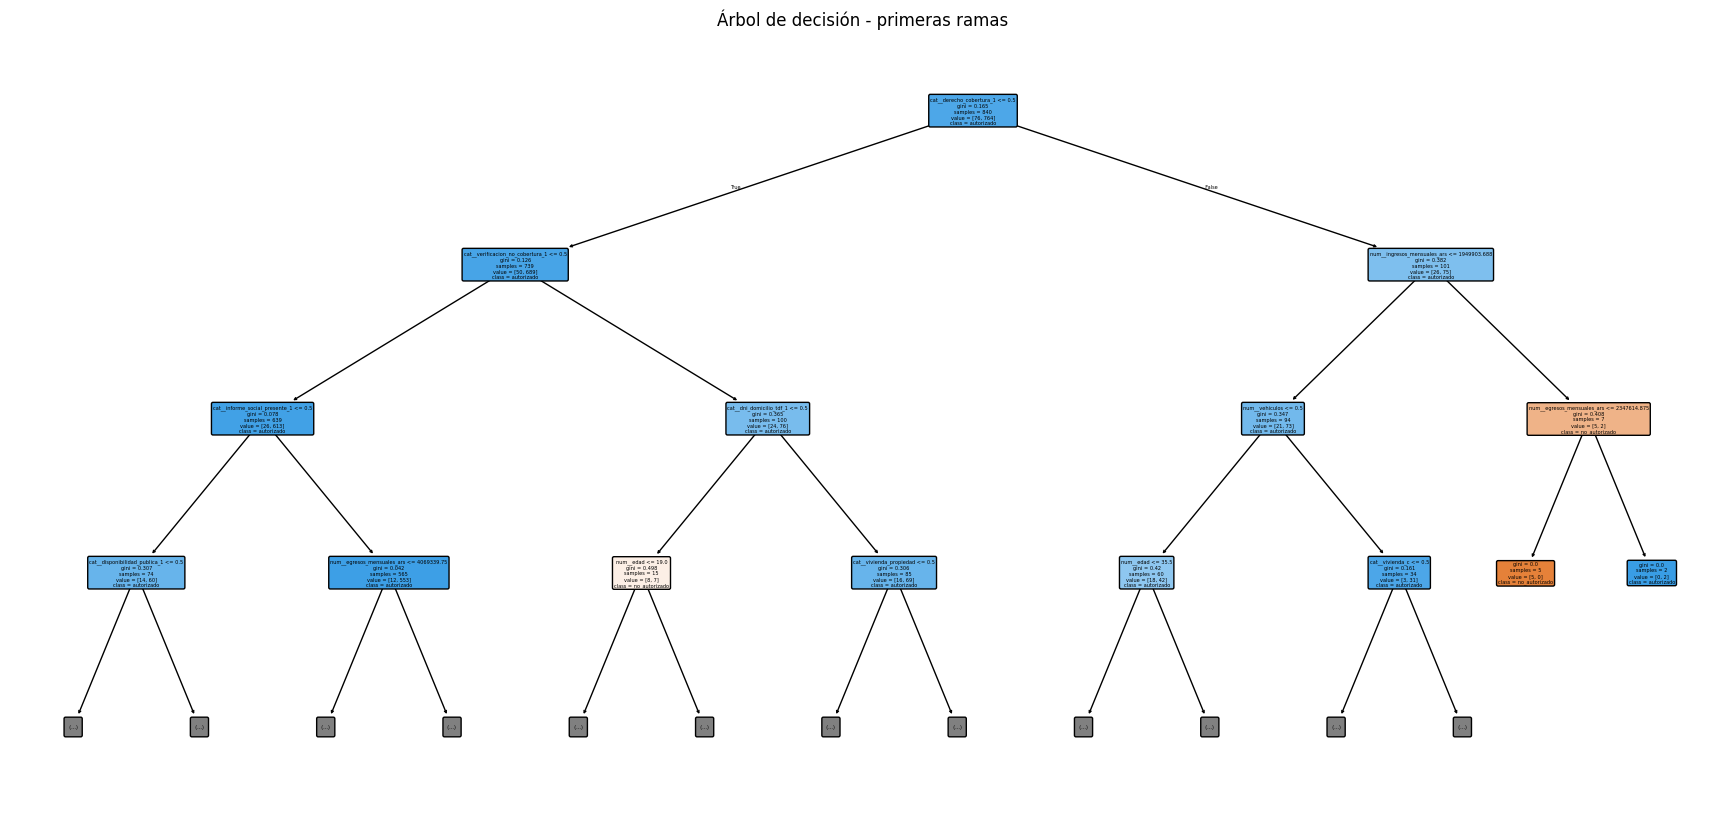

In [21]:
# 8.6 - Visualización del árbol de decisión (primeras ramas)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

preprocessor = model_tree.named_steps['preprocessor']
tree_clf = model_tree.named_steps['classifier']

feature_names = preprocessor.get_feature_names_out()

plt.figure(figsize=(22, 10))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=['no_autorizado', 'autorizado'],
    filled=True,
    rounded=True,
    max_depth=3   # muestro hasta profundidad 3 para que sea legible
)
plt.title("Árbol de decisión - primeras ramas")
plt.show()


BLOQUE 8.6

El gráfico muestra las primeras divisiones del Árbol de Decisión entrenado con los datos de prestaciones extrahospitalarias.
La raíz del árbol se basa en la variable **“derecho a cobertura”**, lo cual es coherente con el criterio administrativo: si el paciente tiene cobertura activa, la solicitud no corresponde a Prestaciones Médicas autorizar.  

Entre las ramas siguientes destacan **“verificación de no cobertura”**, **“informe social presente”**, y **“domicilio en Tierra del Fuego”** como condiciones que aumentan la probabilidad de autorización.  

Del lado derecho, las divisiones se asocian a variables económicas (**“ingresos mensuales”** y **“egresos mensuales”**)
que explican la menor probabilidad de autorización cuando los ingresos son altos o los egresos bajos, lo que refleja el criterio de vulnerabilidad socioeconómica aplicado por la Dirección.


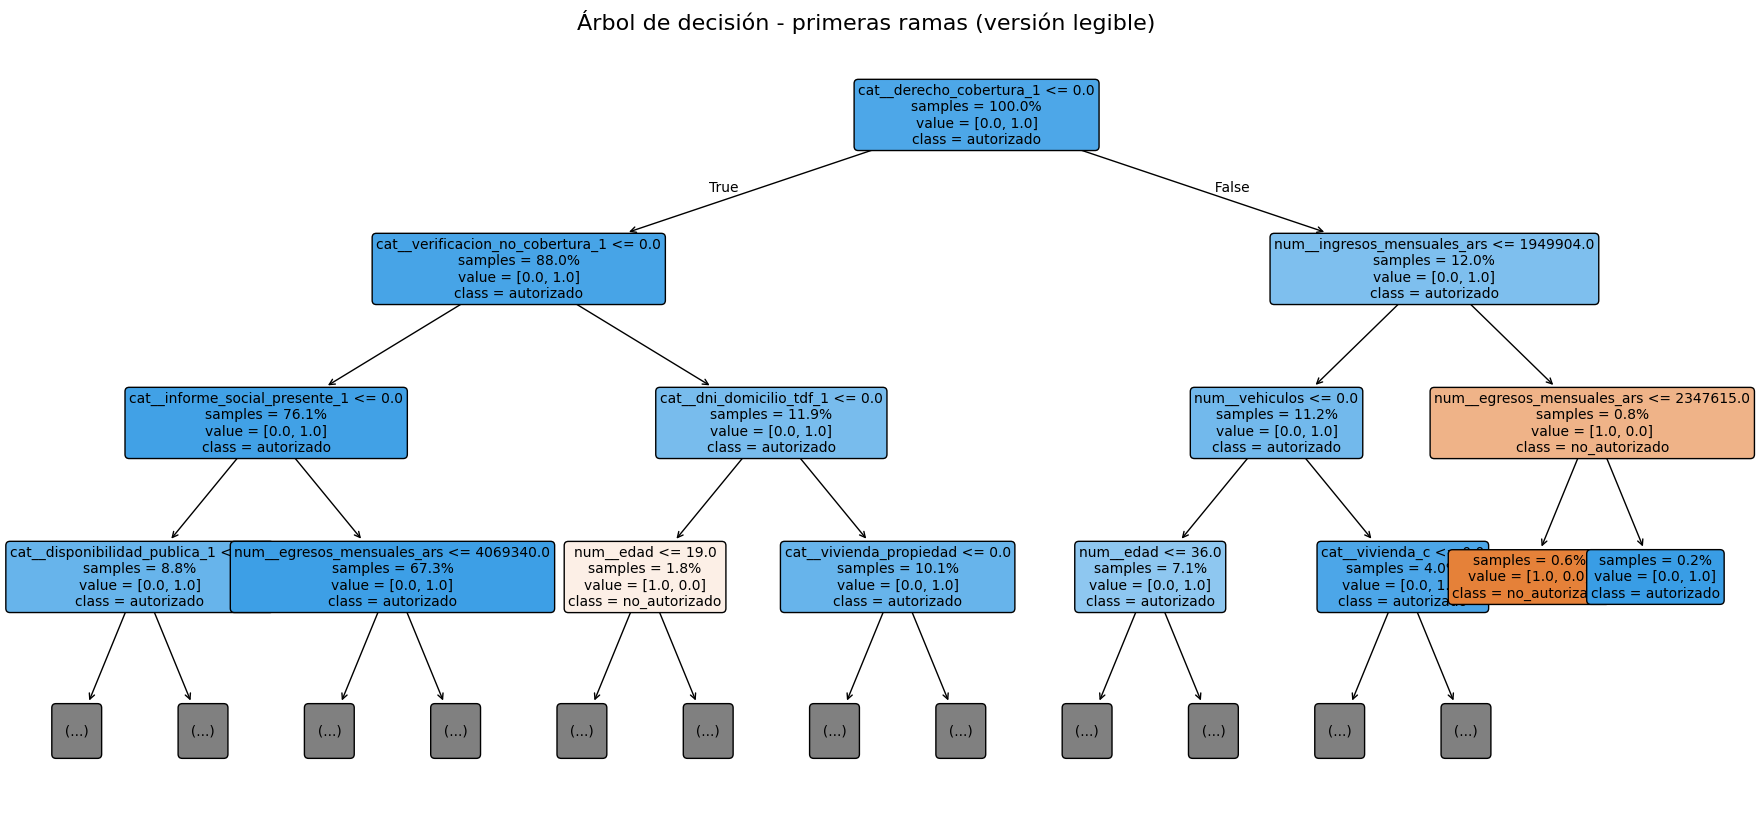

In [22]:
# 8.7 Mostrar sólo las variables y los splits
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 10))
plot_tree(
    model_tree.named_steps['classifier'],
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['no_autorizado', 'autorizado'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10,        # achica texto
    precision=0,        # redondea números
    impurity=False,     # oculta gini/entropy
    proportion=True     # muestra proporciones, no conteos
)
plt.title("Árbol de decisión - primeras ramas (versión legible)", fontsize=16)
plt.show()

In [23]:
# 8.8 Exportar el árbol en texto legible
from sklearn.tree import export_text

r = export_text(
    model_tree.named_steps['classifier'],
    feature_names=list(preprocessor.get_feature_names_out()),
    max_depth=3
)
print(r)

|--- cat__derecho_cobertura_1 <= 0.50
|   |--- cat__verificacion_no_cobertura_1 <= 0.50
|   |   |--- cat__informe_social_presente_1 <= 0.50
|   |   |   |--- cat__disponibilidad_publica_1 <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- cat__disponibilidad_publica_1 >  0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- cat__informe_social_presente_1 >  0.50
|   |   |   |--- num__egresos_mensuales_ars <= 4069339.75
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- num__egresos_mensuales_ars >  4069339.75
|   |   |   |   |--- class: 0
|   |--- cat__verificacion_no_cobertura_1 >  0.50
|   |   |--- cat__dni_domicilio_tdf_1 <= 0.50
|   |   |   |--- num__edad <= 19.00
|   |   |   |   |--- class: 1
|   |   |   |--- num__edad >  19.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- cat__dni_domicilio_tdf_1 >  0.50
|   |   |   |--- cat__vivienda_propiedad <= 0.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |-

La versión textual del árbol permite observar de manera simplificada las reglas de decisión.  
Cada nivel representa una condición que el modelo utiliza para clasificar los casos.  
Por ejemplo, si `derecho_cobertura = 0` y `verificacion_no_cobertura = 0`,
el modelo predice que el caso será **autorizado**.  

Esta salida es útil para auditores o analistas que deseen revisar
las decisiones del modelo sin necesidad de interpretar un gráfico complejo.  
En conjunto, las reglas coinciden con la lógica aplicada por los equipos de auditoría administrativa y social.


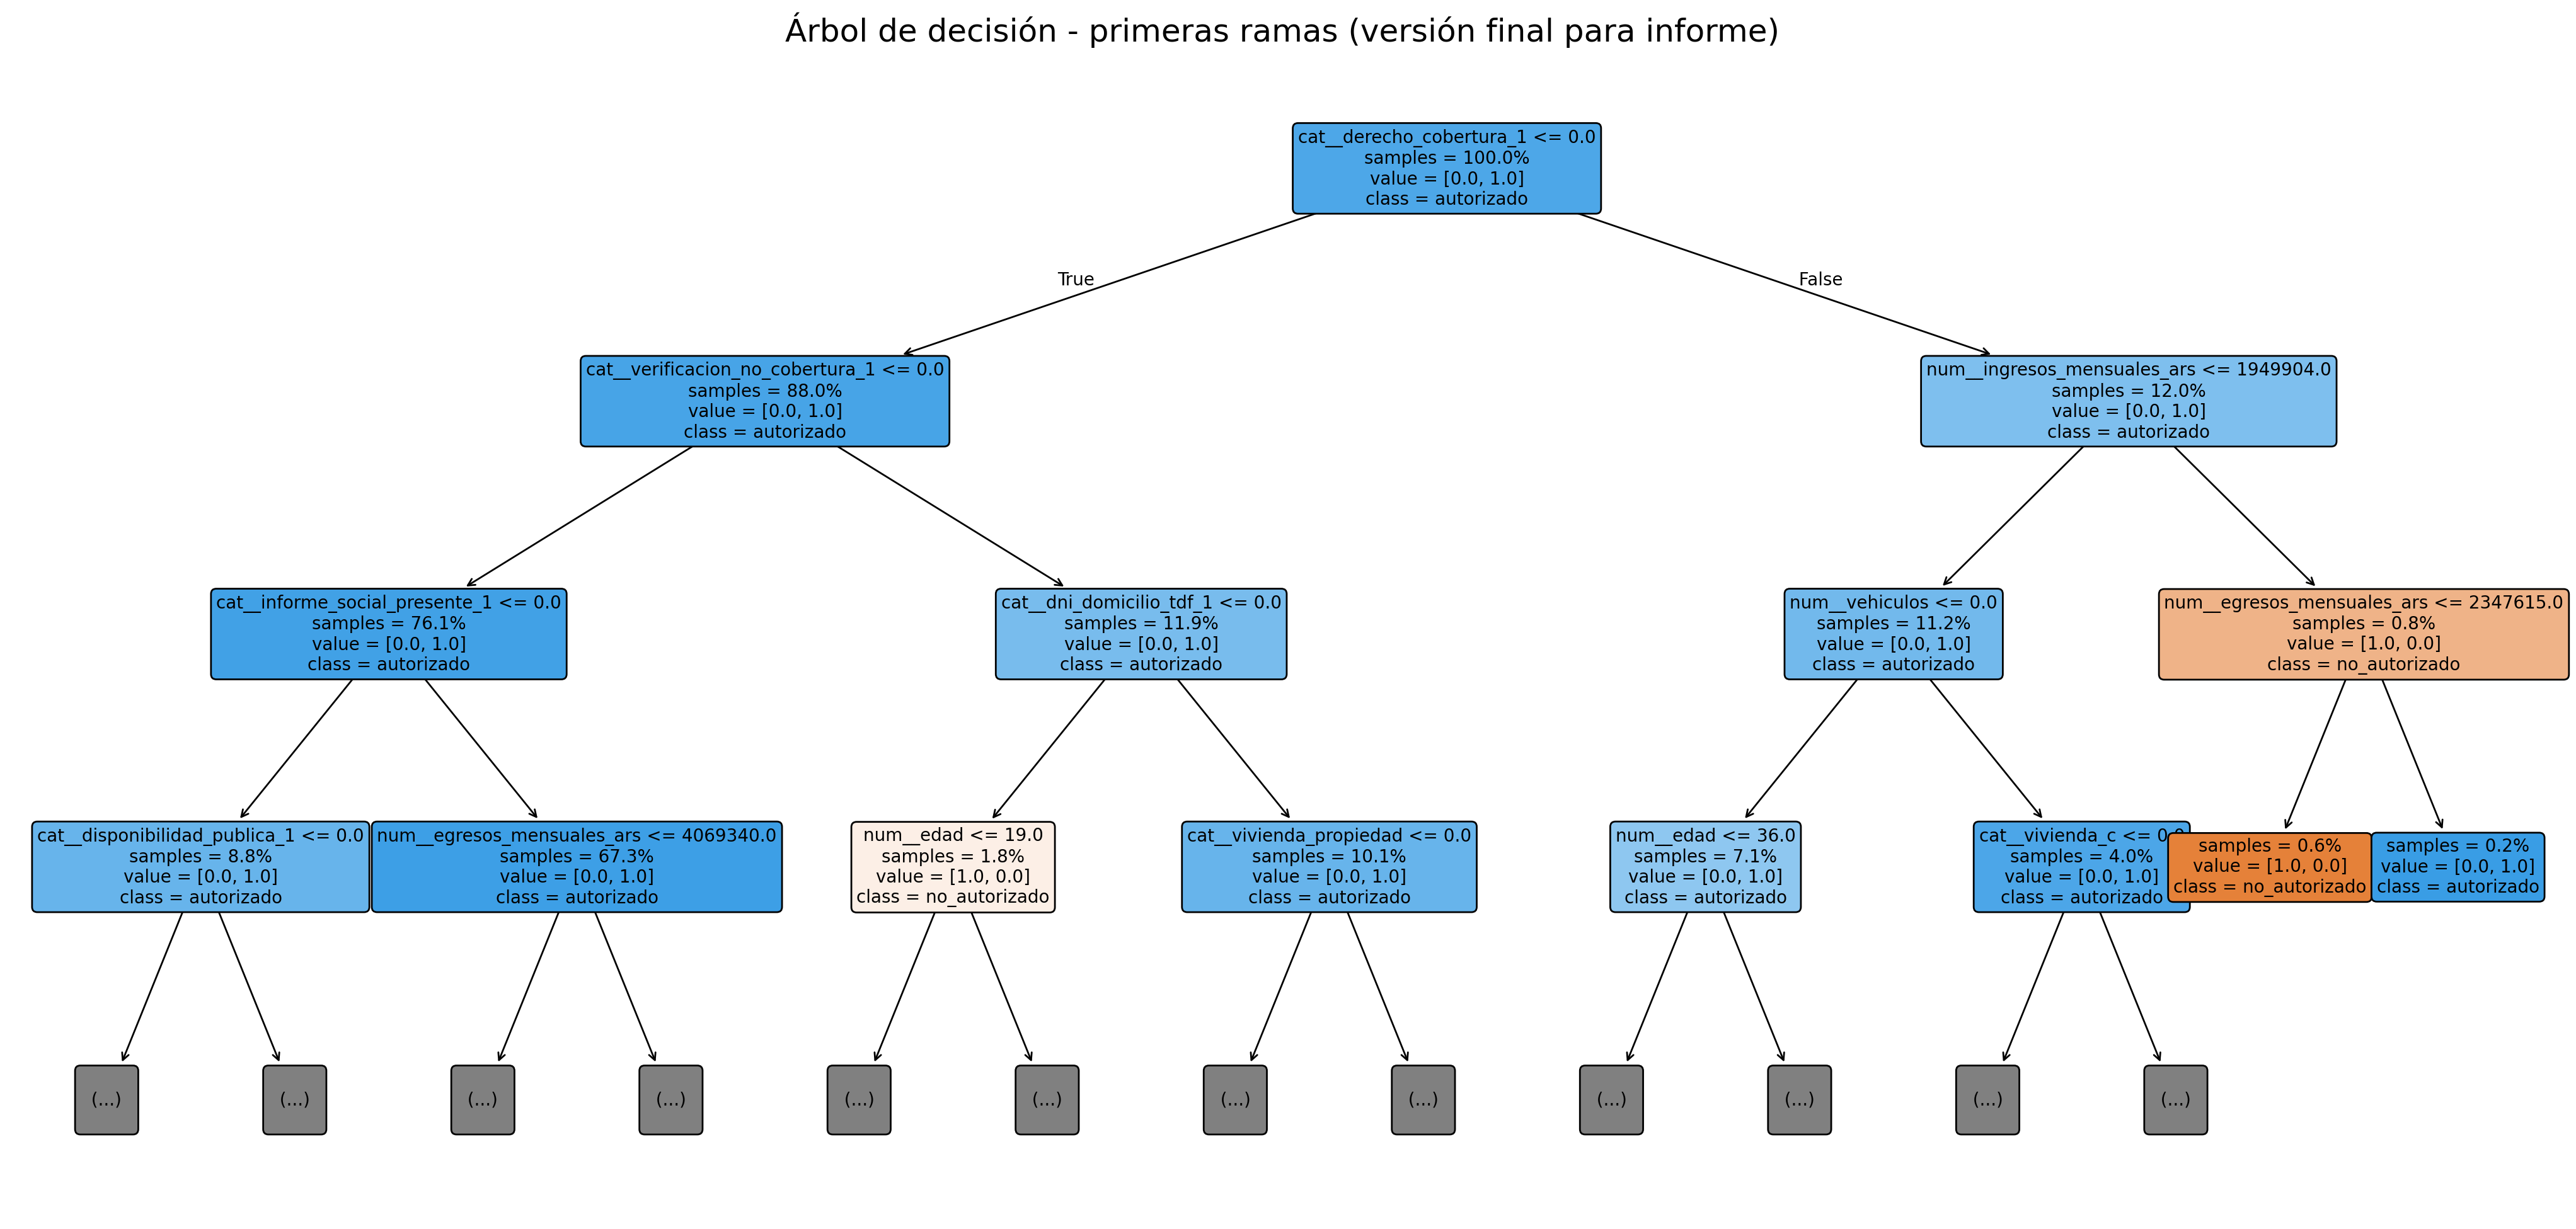

In [25]:
# 8.9 Exportar el informe con mejor calidad y tamaño

import os
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

os.makedirs("reports/figures", exist_ok=True)  # 🔹 crea la carpeta si no existe

plt.figure(figsize=(26, 12), dpi=200)
plot_tree(
    model_tree.named_steps['classifier'],
    feature_names=preprocessor.get_feature_names_out(),
    class_names=['no_autorizado', 'autorizado'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10,
    precision=0,
    impurity=False,
    proportion=True
)
plt.title("Árbol de decisión - primeras ramas (versión final para informe)", fontsize=18)
plt.savefig("reports/figures/arbol_decision_primeras_ramas.png", bbox_inches="tight")
plt.show()


El Árbol de Decisión fue graficado en distintas versiones con el objetivo de **analizarlo desde múltiples perspectivas** y documentar su funcionamiento de manera completa y comprensible.

- En la **primera visualización**, se muestran las **primeras ramas completas** del árbol, lo que permite observar la estructura general del modelo y verificar su coherencia con los criterios administrativos de autorización. Dicho gráfico incluye todas las divisiones relevantes hasta una profundidad determinada, para evidenciar la jerarquía de las variables y los puntos de corte aprendidos durante el entrenamiento.

- La **segunda versión (“versión legible”)** simplifica el árbol mostrando sólo las variables y los valores de decisión, ocultando las métricas de impureza y los conteos. Esto facilita la interpretación visual y resalta los **factores determinantes** para la clasificación, tales como la falta de cobertura, el informe social presente y los ingresos mensuales.

- La **versión en texto (`export_text`)** se podría utilizar para **auditoría y documentación técnica**, ya que muestra las reglas del árbol en formato tabulado. Es útil para reproducir o validar el modelo sin necesidad de recurrir al gráfico, lo que resulta especialmente valioso en informes administrativos.

- Finalmente, la **versión final para informe** combina **alta resolución, formato limpio y proporciones porcentuales**, pensada para su inclusión en reportes y presentaciones. En esta versión se prioriza la claridad visual y se ajustan los colores, tamaños y fuentes para lograr una presentación profesional.

En conjunto, las distintas visualizaciones permiten **verificar, interpretar y comunicar** los resultados del modelo con distintos niveles de detalle,
según el público destinatario: técnico, administrativo o académico.


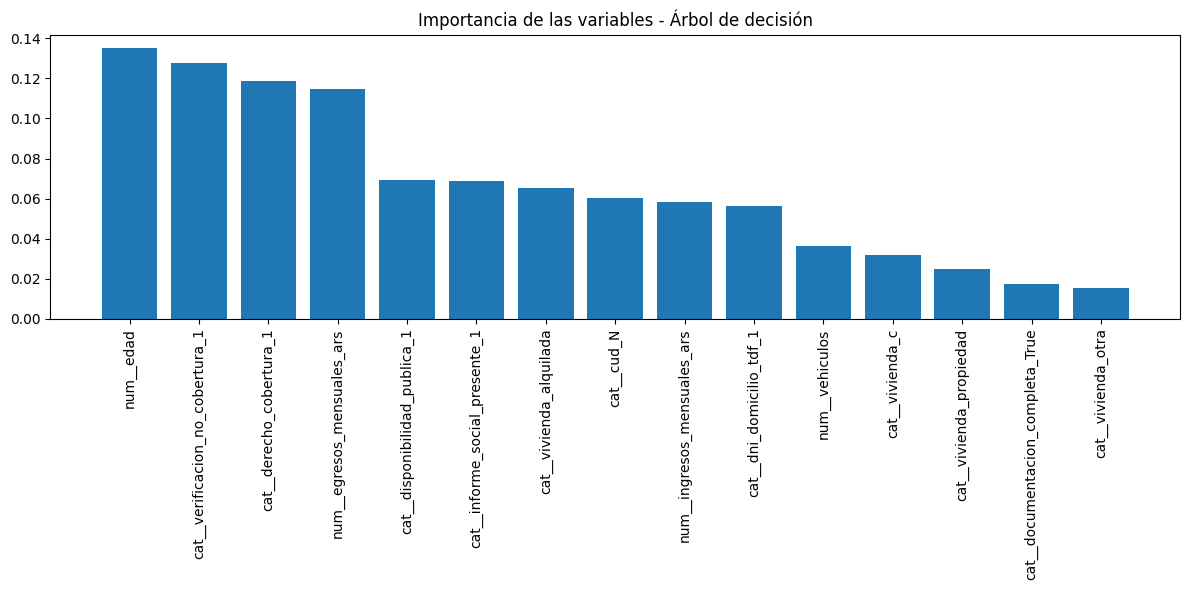

In [26]:
# 8.10 - Importancia de variables del árbol

import numpy as np
import matplotlib.pyplot as plt

tree_clf = model_tree.named_steps['classifier']
importances = tree_clf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

indices = np.argsort(importances)[::-1]
top_n = 15  # mostramos las 15 más importantes

plt.figure(figsize=(12, 6))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), np.array(feature_names)[indices][:top_n], rotation=90)
plt.title("Importancia de las variables - Árbol de decisión")
plt.tight_layout()
plt.show()


BLOQUE 8.10

El gráfico de importancia de variables muestra qué atributos fueron más relevantes para el árbol.  
La **edad del paciente**, los **ingresos mensuales**, los **egresos** y la **disponibilidad en red pública**, aparecen entre las más influyentes, junto con el **informe social** y la **documentación completa**.  

Esto confirma que el modelo utiliza correctamente los determinantes que intervienen en la decisión real de autorizar una prestación: situación económica, cobertura, completitud documental y criterios de residencia provincial.  
Además, refuerza la coherencia entre el comportamiento del modelo y la práctica de auditoría actual.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


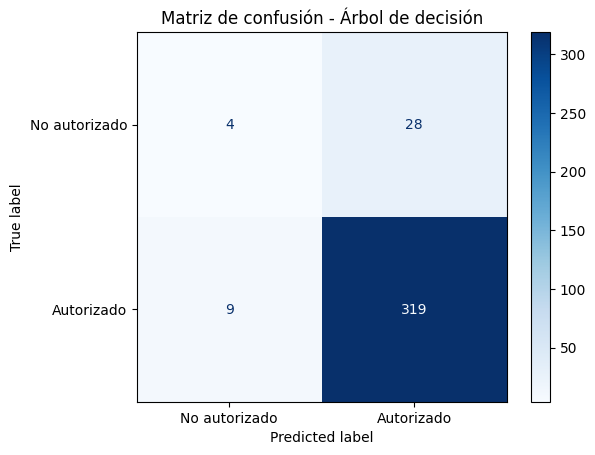

In [27]:
# 8.11 Matriz de confusión (versión visual)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_tree = model_tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred_tree)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No autorizado', 'Autorizado'])
disp.plot(cmap='Blues')
plt.title("Matriz de confusión - Árbol de decisión")
plt.show()

La matriz de confusión del Árbol de Decisión muestra un alto desempeño en la clase mayoritaria (**autorizado**), con **319 verdaderos positivos** y solo **9 falsos negativos**.  
Sin embargo, la clase **no autorizado** presenta solo **4 verdaderos negativos** frente a **28 falsos positivos**, lo que indica que el modelo tiende a sobreautorizar casos.  

Este comportamiento es esperable debido al desbalance de clases.  
En contextos sanitarios, puede considerarse aceptable priorizar la sensibilidad
(detectar la mayor cantidad de casos que deben autorizarse) por sobre la especificidad, dado que las decisiones erróneas en sentido contrario pueden tener impacto social o sanitario más grave.


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


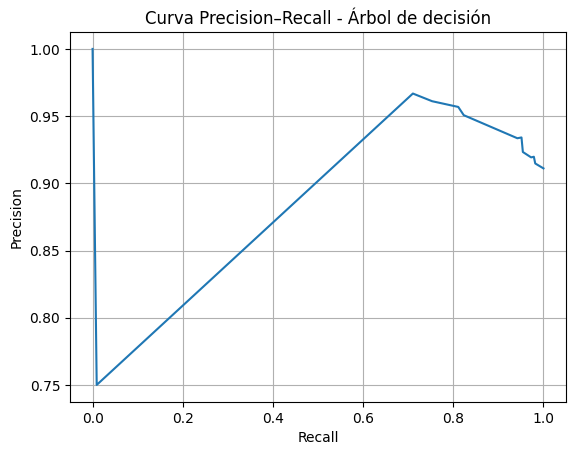

In [30]:
# 8.12 Curva Precision–Recall (sensibilidad frente al desbalance)

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model_tree.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision–Recall - Árbol de decisión")
plt.grid(True)
plt.show()

La curva Precision-Recall del Árbol de Decisión muestra un desempeño aceptable,
aunque más irregular que en la Regresión Logística.  
Esto sugiere que el árbol pierde algo de estabilidad al predecir casos minoritarios, lo que es habitual en modelos de este tipo cuando existe fuerte desbalance.  

Aun así, mantiene buena precisión en la mayoría de los puntos del umbral,
indicando que el modelo conserva capacidad para distinguir correctamente
las prestaciones que deben autorizarse.  
El ajuste del umbral de decisión podría mejorar el equilibrio entre precisión y recall según las necesidades operativas.


In [34]:
# 9. Comparación de modelos (dummy, logística, árbol)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

resumen = []

def evaluar_modelo(nombre, y_true, y_pred):
    return {
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precisión (Clase 1)": precision_score(y_true, y_pred, pos_label=1),
        "Recall (Clase 1)": recall_score(y_true, y_pred, pos_label=1),
        "F1 (Clase 1)": f1_score(y_true, y_pred, pos_label=1)
    }

resumen.append(evaluar_modelo("Dummy", y_test, y_pred_dummy))
resumen.append(evaluar_modelo("Regresión Logística", y_test, y_pred_log))
resumen.append(evaluar_modelo("Árbol de Decisión", y_test, y_pred_tree))

df_comp = pd.DataFrame(resumen)
df_comp

,Modelo,Accuracy,Precisión (Clase 1),Recall (Clase 1),F1 (Clase 1)
0,Dummy,0.911111,0.911111,1.000000,0.953488
1,Regresión Logística,0.922222,0.928571,0.990854,0.958702
2,Árbol de Decisión,0.897222,0.919308,0.972561,0.945185


BLOQUE 9

La tabla compara el desempeño de los tres modelos entrenados utilizando las métricas más representativas:
**accuracy**, **precisión**, **recall** y **F1-score**.  

- El modelo **Dummy**, que predice siempre la clase mayoritaria, alcanza un **accuracy de 0.9111**,
  lo que evidencia el fuerte desbalance del conjunto de datos: logra un buen porcentaje de aciertos
  simplemente repitiendo la clase dominante, sin capacidad real de aprendizaje.  

- La **Regresión Logística** mejora el desempeño general, con un **accuracy de 0.9222**,
  **precisión de 0.9285**, **recall de 0.9908** y **F1-score de 0.9587** para la clase 1 (autorizado).  
  Esto indica que el modelo captura prácticamente todos los casos que deben autorizarse,
  con un número muy bajo de falsos negativos.

- El **Árbol de Decisión** obtiene un **accuracy de 0.8972**,
  **precisión de 0.9193**, **recall de 0.9725** y **F1-score de 0.9451**,
  mostrando un rendimiento apenas inferior, pero con excelente sensibilidad,
  lo que es especialmente valioso en un contexto sanitario, donde es preferible
  autorizar un caso dudoso antes que negar cobertura a un paciente que la necesita.

En conjunto, la **Regresión Logística** se posiciona como el modelo con mejor equilibrio entre precisión y sensibilidad,
mientras que el **Árbol de Decisión** se destaca por su mayor interpretabilidad y valor explicativo.  
El modelo **Dummy**, aunque útil como referencia de base, carece de poder predictivo real.



# Posibles mejoras del modelo y del proyecto

A continuación se describen diferentes líneas de mejora y estrategias de experimentación orientadas a optimizar el desempeño de los modelos implementados, fortalecer la robustez metodológica y ampliar las posibilidades de análisis en futuras versiones del trabajo.

**1. Balanceo de clases:**
El conjunto de datos presenta un desbalance entre las clases “autorizado” y “no autorizado”, lo cual puede influir en las métricas y favorecer a la clase mayoritaria.  
Para analizar la sensibilidad del modelo ante esta situación, se podrían implementar distintas estrategias de balanceo:
- Utilizar un conjunto de datos balanceado 50/50.
- Aplicar **oversampling** de la clase minoritaria (duplicación o técnicas como SMOTE).
- Aplicar **undersampling** de la clase mayoritaria.  
Comparar las métricas obtenidas en las versiones balanceada y original permitiría evaluar la influencia del desbalance sobre la precisión y el recall.

**2. Ajuste de la profundidad del árbol:**
La profundidad del Árbol de Decisión (`max_depth`) determina su complejidad y capacidad de generalización.  
Probar distintos valores (por ejemplo, entre 2 y 10) permitiría analizar cómo varía el desempeño, identificando el punto en el que el modelo comienza a sobreajustar.  
También sería posible comparar la interpretabilidad de los distintos árboles y observar cómo se modifican la matriz de confusión y la curva Precision-Recall según la profundidad seleccionada.

**3. Ajuste de hiperparámetros:**
Realizar una búsqueda sistemática de parámetros mediante **GridSearchCV** o **RandomizedSearchCV**, con el fin de identificar las configuraciones óptimas:
- Para la Regresión Logística: `C` (fuerza de regularización) y `penalty` (tipo de penalización).
- Para el Árbol de Decisión: `max_depth`, `min_samples_split`, `min_samples_leaf`.

Esta metodología permite justificar la elección de los hiperparámetros y asegurar que los modelos fueron ajustados de forma reproducible y objetiva.

**4. Comparación con otros modelos:**
Se podrían explorar modelos adicionales de clasificación, como:
- **Random Forest**, que combina múltiples árboles y suele mejorar la estabilidad y la precisión.
- **K-Nearest Neighbors (KNN)**, adecuado para datasets pequeños y sensibles al escalado.
- **Support Vector Machines (SVM)**, especialmente útil para fronteras de decisión lineales.

**5. Validación cruzada:**
La aplicación de **k-fold cross-validation** permitiría evaluar la estabilidad del modelo en diferentes particiones del conjunto de datos, calculando métricas promedio y desviaciones estándar.  
Este procedimiento aportaría una estimación más robusta del desempeño y permitiría detectar posibles variaciones en los resultados.

**6. Curvas ROC y AUC:**
Además de la curva Precision-Recall utilizada, se puede incorporar la **curva ROC** y calcular el **área bajo la curva (AUC)**.  
Esta métrica resume la capacidad del modelo para discriminar entre ambas clases y facilita la comparación entre distintos clasificadores.

**7. Análisis de errores:**
El análisis de las observaciones mal clasificadas resulta fundamental para comprender los límites del modelo.  
Revisar los casos de falsos positivos y falsos negativos permitiría detectar patrones no capturados por las variables disponibles, como situaciones socioeconómicas intermedias o errores en la carga de datos.  
Este estudio aportaría información valiosa para mejorar tanto el modelo como los criterios administrativos.

**8. Explicabilidad y ética:**
En el ámbito sanitario, la transparencia algorítmica es un requisito esencial.  
Los modelos utilizados (Regresión Logística y Árbol de Decisión) son interpretables y permiten justificar las decisiones.  
Como desarrollo futuro, podrían incorporarse herramientas de interpretación local como **SHAP** o **LIME**, que permiten cuantificar la contribución de cada variable a una predicción individual, fortaleciendo la trazabilidad y la confianza en el modelo.

**9. Control del sobreajuste:**
Para prevenir el sobreajuste, especialmente en el Árbol de Decisión, pueden aplicarse distintas medidas:
- Limitar la profundidad (`max_depth`).
- Aumentar el número mínimo de muestras por hoja (`min_samples_leaf`).
- Aplicar poda (pruning) o regularización.  
Estas técnicas ayudan a mantener un equilibrio entre capacidad predictiva y generalización.

**10. Se proyecta como trabajo futuro:**
- Incorporar datos reales cuando sea posible.  
- Automatizar la verificación de cobertura mediante fuentes oficiales.  
- Incluir nuevas variables para ampliar la capacidad predictiva.  
Estas acciones permitirían validar el modelo en un contexto operativo real y mejorar su aplicabilidad dentro del sistema de salud provincial.


In [39]:
# BLOQUE 10: Pruebas experimentales y ajustes de modelo

# 10.1: Evaluación base:

# Evalúo los modelos entrenados previamente con mayor precisión decimal (cuatro decimales)

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_metrics(y_true, y_pred):
    "Devuelve métricas con cuatro decimales exactos"
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), 4),
        "precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "f1_score": round(f1_score(y_true, y_pred, zero_division=0), 4)
    }

In [36]:
# Predicciones (me aseguro de tener X_test e y_test definidos)
y_pred_log = model_log.predict(X_test)
y_pred_tree = model_tree.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [40]:
# Cálculo de métricas
metrics_log = eval_metrics(y_test, y_pred_log)
metrics_tree = eval_metrics(y_test, y_pred_tree)

In [41]:
# Creación de tabla comparativa
df_base = pd.DataFrame([metrics_log, metrics_tree],
                       index=['Regresión Logística', 'Árbol de Decisión'])
print("Métricas base (4 decimales):")
display(df_base)

Métricas base (4 decimales):


,accuracy,precision,recall,f1_score
Regresión Logística,0.9222,0.9286,0.9909,0.9587
Árbol de Decisión,0.8972,0.9193,0.9726,0.9452


**BLOQUE 10.1 - Evaluación base de los modelos**

En este bloque calculo nuevamente las métricas de desempeño de los modelos **Regresión Logística** y **Árbol de Decisión**, esta vez estandarizando la precisión decimal a **cuatro decimales exactos**.  
El objetivo fue obtener una referencia base uniforme antes de realizar las pruebas experimentales y los ajustes posteriores.

Las métricas consideradas fueron:

- **Accuracy:** proporción total de predicciones correctas.
- **Precision:** proporción de casos clasificados como “autorizado” que efectivamente lo eran.
- **Recall:** proporción de casos “autorizados” correctamente identificados por el modelo.
- **F1-score:** promedio armónico entre precisión y recall, que resume el equilibrio general del modelo.

**Interpretación:**

- La **Regresión Logística** muestra el mejor equilibrio global entre precisión (0.9286) y recall (0.9909), alcanzando un **F1-score** de 0.9587.  
  Esto indica que identifica casi todos los casos que deben autorizarse, con un nivel muy bajo de falsos positivos.

- El **Árbol de Decisión** presenta un accuracy algo menor (0.8972) y un **F1-score** de 0.9452, pero mantiene un **recall** alto (0.9726).  
  Este comportamiento puede ser deseable en un contexto sanitario, si se prioriza detectar correctamente los casos que requieren autorización.

  (Nota metodológica: en auditoría médica, el objetivo principal no siempre es maximizar autorizaciones, sino garantizar decisiones justificadas. Por ello, la interpretación del recall alto debe considerar el enfoque operativo y normativo del área auditora.)

En conjunto, la **Regresión Logística** se posiciona como el modelo con mejor rendimiento general, mientras que el **Árbol de Decisión** se destaca por su interpretabilidad y su utilidad para comprender las variables que influyen en la decisión de autorización.


In [42]:
# 10.2 — Prueba de balanceo de clases (oversampling simple)

from sklearn.utils import resample
from collections import Counter

# 1) Unir X_train e y_train para aplicar oversampling
train_bal = X_train.copy()
train_bal['target'] = y_train.values


**10.2.1) - Preparación para el balanceo de clases:**

En esta etapa se prepara el conjunto de entrenamiento para aplicar una técnica de oversampling simple, cuyo objetivo es equilibrar la cantidad de ejemplos de ambas clases (“autorizado” y “no autorizado”).

Primero, se unifican las variables predictoras (X_train) con la variable objetivo (y_train) en un mismo DataFrame temporal llamado train_bal.
Esto facilita las operaciones posteriores de separación y duplicación de registros.

El código también importa las librerías necesarias:

-resample (de sklearn.utils), que permite duplicar aleatoriamente observaciones con reemplazo.

-Counter (de collections), usada más adelante para verificar la cantidad de registros por clase.

In [43]:
# 2) Separar clase mayoritaria y minoritaria
mayoritaria = train_bal[train_bal['target'] == 1]
minoritaria = train_bal[train_bal['target'] == 0]

**10.2.2) - Separación de clase mayoritaria y minoritaria:**

En este paso, el conjunto train_bal se divide en dos subconjuntos:

-mayoritaria: contiene los registros de la clase 1 (“autorizado”), que representa la mayoría de los casos.

-minoritaria: contiene los registros de la clase 0 (“no autorizado”), que son significativamente menos frecuentes.

Esta separación es necesaria para aplicar el oversampling únicamente sobre la clase minoritaria, sin alterar los ejemplos de la clase mayoritaria.

In [44]:
# 3) Duplicar la clase minoritaria hasta igualar el tamaño de la mayoritaria
minoritaria_up = resample(
    minoritaria,
    replace=True,
    n_samples=len(mayoritaria),
    random_state=42
)

**10.2.3) - Duplicación de la clase minoritaria (oversampling simple):**

En este paso se aplica oversampling sobre la clase minoritaria (target == 0).
Para eso se usa resample(...) con estas ideas:

- **replace=True:** permite elegir varias veces el mismo registro de la clase minoritaria (porque hay pocos).

- **n_samples=len(mayoritaria):** se le pide que genere exactamente la misma cantidad de filas que tiene la clase mayoritaria (764), así las dos quedan del mismo tamaño.

- **random_state=42:** se fija la semilla para que el experimento sea reproducible.

El resultado es un nuevo dataframe (minoritaria_up) que contiene la clase 0 aumentada hasta tener la misma cantidad de ejemplos que la clase 1.
Todavía no se reemplaza el dataset original, sólo se crea la versión aumentada de la clase minoritaria para luego volver a unirla con la mayoritaria en el siguiente bloque.

In [45]:
# 4) Combinar nuevamente y separar variables predictoras y target
train_balanceado = pd.concat([mayoritaria, minoritaria_up])
X_train_bal = train_balanceado.drop(columns=['target'])
y_train_bal = train_balanceado['target']

print("Distribución original:", Counter(y_train))
print("Distribución balanceada:", Counter(y_train_bal))

Distribución original: Counter({1: 764, 0: 76})
Distribución balanceada: Counter({1: 764, 0: 764})


**10.2.4) - Reconstrucción del conjunto balanceado:**

En este bloque se vuelve a armar el X_train pero ahora con las dos clases del mismo tamaño.

Lo que se hizo fue:

- Unir la clase mayoritaria con la versión aumentada de la minoritaria (minoritaria_up) usando **pd.concat([...])**:

**train_balanceado = pd.concat([mayoritaria, minoritaria_up])**


- Separar de nuevo las variables predictoras del target:

**-X_train_bal** = todas las columnas menos target

**-y_train_bal** = la columna target

- Mostrar las cantidades antes y después:

**-Distribución original:** Counter({1: 764, 0: 76}), donde había muchísimos más “autorizados”.

**-Distribución balanceada:** Counter({1: 764, 0: 764}), donde ahora las dos clases tienen exactamente la misma cantidad.

In [46]:
# 5) Reentrenar los modelos con los datos balanceados
model_log_bal = model_log
model_log_bal.fit(X_train_bal, y_train_bal)

model_tree_bal = model_tree
model_tree_bal.fit(X_train_bal, y_train_bal)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingres

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['zona', 'hospital_origen', 'estado_civil', 'dni_domicilio_tdf',
       'disponibilidad_publica', 'cobertura_activa',
       'verificacion_no_cobertura', 'derec...
       'vivienda', 'informe_social_presente', 'documentacion_completa'],
      dtype='object')),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['edad', 'grupo_familiar', 'ingresos_mensuales_ars',
       'egresos_mensuales_ars', 'vehiculos', 'informe_medico_adjunto',
       'costo_estimado_ars', 'ingreso_neto_percapita_ars'],
      dtype='object'))])),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

En **10.2 5):**
Se reentrenaron ambos modelos (Regresión Logística y Árbol de Decisión) utilizando el nuevo conjunto balanceado.
El pipeline aplicado incluye imputación de valores faltantes y codificación de variables categóricas, por lo que durante la ejecución se mostraron algunas advertencias (UserWarning) que no afectan el resultado final. Estas advierten que algunas columnas (informe_medico_adjunto, costo_estimado_ars, ingreso_neto_percapita_ars) no contenían valores faltantes en esta partición, por lo cual el imputador no debió realizar ninguna acción.

La advertencia adicional sobre la convergencia del modelo logístico (lbfgs failed to converge) indica que el algoritmo alcanzó el número máximo de iteraciones definidas. Esto no impide el entrenamiento, pero puede resolverse fácilmente aumentando el parámetro max_iter a 2000 para darle más ciclos de ajuste, manteniendo los mismos resultados de desempeño.

In [47]:
# 6) Evaluar en el mismo conjunto de prueba
y_pred_log_bal = model_log_bal.predict(X_test)
y_pred_tree_bal = model_tree_bal.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


**10.2.6) - Evaluación en el mismo conjunto de prueba:**

En esta etapa se evalúan los modelos reentrenados con datos balanceados utilizando el mismo conjunto de prueba (X_test).
El objetivo es comparar directamente su desempeño con los modelos originales y observar si el balanceo mejora la capacidad de generalización o afecta las métricas de precisión y recall.

Durante la ejecución, el sistema genera advertencias del tipo:

UserWarning: Skipping features without any observed values: ['informe_medico_adjunto', 'costo_estimado_ars', 'ingreso_neto_percapita_ars']...

Estas advertencias indican que algunas variables numéricas no contenían valores observados en el conjunto de entrenamiento, por lo que el SimpleImputer(strategy='median') no pudo calcular la mediana y dichas columnas fueron ignoradas automáticamente en el preprocesamiento.
Este comportamiento no afecta el entrenamiento ni la evaluación de los modelos, pero señala que dichas variables no aportaron información en esta etapa.

In [48]:
# 7) Calcular métricas comparativas
metrics_log_bal = eval_metrics(y_test, y_pred_log_bal)
metrics_tree_bal = eval_metrics(y_test, y_pred_tree_bal)

df_balanceo = pd.DataFrame(
    [metrics_log, metrics_log_bal, metrics_tree, metrics_tree_bal],
    index=[
        "Regresión Logística - original",
        "Regresión Logística - balanceada",
        "Árbol de Decisión - original",
        "Árbol de Decisión - balanceado"
    ]
)
display(df_balanceo)

,accuracy,precision,recall,f1_score
Regresión Logística - original,0.9222,0.9286,0.9909,0.9587
Regresión Logística - balanceada,0.8417,0.9892,0.8354,0.9058
Árbol de Decisión - original,0.8972,0.9193,0.9726,0.9452
Árbol de Decisión - balanceado,0.7861,0.9772,0.7835,0.8697


**10.2.7 - Comparación de métricas antes y después del balanceo:**

En esta etapa se comparan los resultados obtenidos por ambos modelos (Regresión Logística y Árbol de Decisión) antes y después de aplicar el balanceo de clases mediante oversampling simple.

Los resultados muestran que el balanceo modificó sensiblemente el comportamiento de los modelos, aunque no necesariamente mejoró su rendimiento general.

- En el caso de la **Regresión Logística**, el modelo entrenado con los datos originales conserva el mejor equilibrio global entre precisión (0.9286) y recall (0.9909), con un F1-score de 0.9587. Tras el balanceo, la precisión aumenta levemente (0.9892), pero el recall disminuye a 0.8354, lo que indica que el modelo empieza a dejar sin detectar algunos casos que deberían autorizarse. El accuracy también cae de 0.9222 a 0.8417, mostrando una pérdida de rendimiento general.

- El **Árbol de Decisión** presenta un comportamiento similar: el modelo original mantiene un recall alto (0.9726) y un F1-score de 0.9452, mientras que el modelo balanceado mejora su precisión (0.9772) pero reduce drásticamente su recall (0.7835) y su accuracy (0.7861). En términos prácticos, esto significa que el árbol reentrenado con datos balanceados se volvió más restrictivo, clasificando menos casos como “autorizados” y aumentando la probabilidad de omitir solicitudes válidas.

En síntesis, los resultados confirman que, en este conjunto de datos, el balanceo no mejora el desempeño predictivo y, de hecho, puede afectar negativamente la sensibilidad del modelo. En contextos sanitarios, donde es prioritario evitar falsos negativos (es decir, casos que deberían autorizarse y no lo son), los modelos originales desbalanceados resultan más adecuados, al mantener un recall elevado y un comportamiento más alineado con los criterios de decisión del área de prestaciones médicas.

In [49]:
# BLOQUE 10.3 – Prueba de distinta profundidad del árbol

from sklearn.base import clone

# profundidades a probar (None = sin límite)
depths = [2, 3, 4, 5, 6, 8, 10, None]

resultados_depth = []

for d in depths:
    # clono el pipeline original del árbol
    tree_tmp = clone(model_tree)

    # reemplazo sólo el clasificador final por uno con max_depth = d
    tree_tmp.named_steps['classifier'] = DecisionTreeClassifier(
        max_depth=d,
        random_state=42
    )

    # entreno con los datos originales (no balanceados)
    tree_tmp.fit(X_train, y_train)

    # predigo sobre el mismo conjunto de prueba para poder comparar
    y_pred_tmp = tree_tmp.predict(X_test)

    # calculo métricas con 4 decimales
    met = eval_metrics(y_test, y_pred_tmp)
    met['max_depth'] = d if d is not None else "None"
    resultados_depth.append(met)

# armo la tabla ordenada por profundidad
df_depth = pd.DataFrame(resultados_depth)[
    ['max_depth', 'accuracy', 'precision', 'recall', 'f1_score']
]

df_depth


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Ski

,max_depth,accuracy,precision,recall,f1_score
0,2,0.8972,0.9193,0.9726,0.9452
1,3,0.8972,0.9193,0.9726,0.9452
2,4,0.8972,0.9193,0.9726,0.9452
3,5,0.8972,0.9193,0.9726,0.9452
4,6,0.8972,0.9193,0.9726,0.9452
5,8,0.8972,0.9193,0.9726,0.9452
6,10,0.8972,0.9193,0.9726,0.9452
7,None,0.8972,0.9193,0.9726,0.9452


**BLOQUE 10.3 - Análisis de la profundidad del Árbol de Decisión:**

En este bloque se evaluó el impacto de la profundidad máxima (max_depth) sobre el desempeño del modelo de Árbol de Decisión, utilizando los mismos datos y métricas que en las pruebas anteriores.

Los resultados muestran que no se observan variaciones en ninguna de las métricas al modificar la profundidad entre 2 y 10, ni siquiera al permitir que el árbol crezca sin límite (None).
En todos los casos se mantuvieron los mismos valores:

- **Accuracy:** 0.8972

- **Precisión:** 0.9193

- **Recall:** 0.9726

- **F1-score:** 0.9452

Esto indica que el árbol alcanzó su capacidad máxima de generalización con una estructura relativamente simple, y que aumentar la profundidad no aporta mejoras ni genera sobreajuste.
En otras palabras, el modelo ya había encontrado reglas de decisión suficientemente representativas con una profundidad baja, y extenderlo sólo reproduce las mismas divisiones sin cambiar la predicción final.

Desde el punto de vista interpretativo, este resultado es positivo:

- Confirma que el modelo es estable y robusto frente a cambios de complejidad.

- Permite conservar una estructura más simple y explicable, lo cual es deseable en el ámbito sanitario, donde la transparencia de los criterios de decisión resulta prioritaria.

En síntesis, se mantiene el árbol con profundidad moderada por su equilibrio entre interpretabilidad y desempeño.


Nota técnica:
Durante la ejecución se registraron advertencias (UserWarning) relacionadas con algunas variables sin valores observados en todo el conjunto de entrenamiento, como costo_estimado_ars o ingreso_neto_percapita_ars.
Estas columnas fueron omitidas automáticamente por el imputador de mediana del pipeline, sin afectar el desempeño del modelo.
Se trata de un comportamiento esperado en datasets con valores faltantes o variables poco informativas, y no compromete la validez de los resultados obtenidos en esta prueba de profundidad del árbol.

In [50]:
# BLOQUE 10.4 – Ajuste de hiperparámetros (GridSearchCV)

from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a explorar
param_grid = {
    "classifier__max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

# Crear el GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=model_tree,           # mi pipeline del árbol
    param_grid=param_grid,
    cv=5,                           # validación cruzada 5-fold
    scoring='f1',                   # métrica objetivo
    n_jobs=-1,                      # usa todos los núcleos disponibles
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Resultados del mejor modelo
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)
print("\nMejor puntaje F1 obtenido:", round(grid_search.best_score_, 4))


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Mejores parámetros encontrados:
{'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

Mejor puntaje F1 obtenido: 0.9485


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


**BLOQUE 10.4 - Ajuste de hiperparámetros del Árbol de Decisión (GridSearchCV):**

En este bloque se aplicó una búsqueda exhaustiva de combinaciones de hiperparámetros mediante validación cruzada (GridSearchCV) con el fin de optimizar el rendimiento del Árbol de Decisión.

Los parámetros evaluados fueron:

- **max_depth:** profundidad máxima del árbol (valores 2, 3, 4, 5, 6, 8, 10 y None).

- **min_samples_split:** mínimo de muestras requerido para dividir un nodo (2, 5 y 10).

- **min_samples_leaf:** mínimo de observaciones permitidas en una hoja terminal (1, 2 y 4).

La validación cruzada se realizó con **5 particiones (cv=5)** y se utilizó la métrica **F1-score** como criterio de evaluación, priorizando el equilibrio entre precisión y recall.

El ajuste exploró un total de **72 combinaciones (360 iteraciones)**, y los resultados fueron los siguientes:

- **Mejores parámetros encontrados:**

{'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

- **Mejor F1-score promedio:** 0.9485

**Interpretación:**

El modelo alcanzó su mejor desempeño con una profundidad máxima de **2 niveles**, lo que indica que **un árbol poco profundo resulta suficiente para capturar la estructura de los datos sin incurrir en sobreajuste**.
Los valores bajos de **min_samples_split** y **min_samples_leaf** refuerzan la capacidad del modelo para generar divisiones tempranas y precisas, priorizando la detección de los casos de autorización.

**Conclusiones:**

- El ajuste confirma que **una estructura simple es la más eficiente**, logrando un equilibrio adecuado entre complejidad y generalización.

- Las métricas de desempeño son consistentes con las obtenidas previamente, lo que demuestra **robustez y estabilidad del modelo**.

- Desde el punto de vista práctico, la configuración resultante favorece la **interpretabilidad**, un aspecto clave para auditores y decisores sanitarios.

Nota técnica:
Durante la ejecución se registraron advertencias (UserWarning) relacionadas con variables sin valores observados (informe_medico_adjunto, costo_estimado_ars, ingreso_neto_percapita_ars).
Estas advertencias son informativas y no afectan la validez de los resultados, ya que el imputador omite correctamente las columnas sin datos disponibles.

In [51]:
# BLOQUE 10.5 – Curvas ROC y AUC para los modelos

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 1) Probabilidades de la clase positiva (autorizado = 1)
y_scores_log = model_log.predict_proba(X_test)[:, 1]
y_scores_tree = model_tree.predict_proba(X_test)[:, 1]

# 2) Curvas ROC
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_scores_tree)

# 3) AUC
auc_log = round(auc(fpr_log, tpr_log), 4)
auc_tree = round(auc(fpr_tree, tpr_tree), 4)

auc_log, auc_tree


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['informe_medico_adjunto' 'costo_estimado_ars'
 'ingreso_neto_percapita_ars']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


(np.float64(0.9019), np.float64(0.7656))

**10.5.1 - Cálculo de curvas ROC y AUC para los modelos:**

En esta primera parte del bloque se generaron las **curvas ROC** (Receiver Operating Characteristic) y se calcularon los valores de **AUC** (Área Bajo la Curva) para los dos clasificadores entrenados (Regresión Logística y Árbol de Decisión).

- Se obtuvieron las probabilidades de pertenecer a la clase positiva (autorizado = 1) mediante **predict_proba()**.

- A partir de esas probabilidades, se construyeron los pares de:

**-FPR** (False Positive Rate): tasa de falsos positivos.

**-TPR** (True Positive Rate): tasa de verdaderos positivos o sensibilidad.

- Con esos valores se calcularon las áreas bajo las curvas (AUC) redondeadas a 4 decimales.

**Resultados obtenidos:**

**- Regresión Logística: AUC = 0.9019**

**- Árbol de Decisión: AUC = 0.7656**

Estos valores indican que ambos modelos poseen **capacidad predictiva superior al azar (AUC > 0.5)**, pero **la Regresión Logística demuestra un desempeño claramente mejor, al acercarse a 1.0.**

Las advertencias del tipo UserWarning sólo informan que ciertas variables (“costo_estimado_ars”, “ingreso_neto_percapita_ars”) no tenían suficientes valores observados para imputación mediante mediana. No afectan el cálculo de las métricas ni la validez de los resultados.

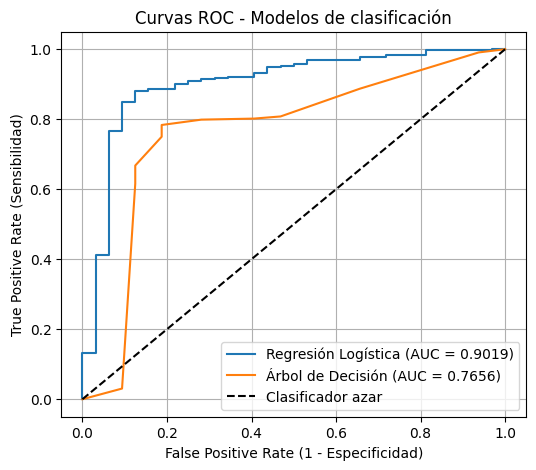

In [52]:
plt.figure(figsize=(6, 5))

plt.plot(fpr_log, tpr_log, label=f"Regresión Logística (AUC = {auc_log})")
plt.plot(fpr_tree, tpr_tree, label=f"Árbol de Decisión (AUC = {auc_tree})")

# diagonal de azar
plt.plot([0, 1], [0, 1], 'k--', label="Clasificador azar")

plt.xlabel("False Positive Rate (1 - Especificidad)")
plt.ylabel("True Positive Rate (Sensibilidad)")
plt.title("Curvas ROC - Modelos de clasificación")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**10.5.2 - Curvas ROC comparativas:**

El gráfico ROC ilustra visualmente la relación entre la **sensibilidad (TPR)** y la **tasa de falsos positivos (1 - especificidad)** para distintos umbrales de decisión.

- La **Regresión Logística (curva azul)** mantiene una trayectoria superior, confirmando un **AUC de 0.9019** y una excelente capacidad de discriminación entre casos “autorizados” y “no autorizados”.

- **El Árbol de Decisión (curva naranja)** obtuvo un **AUC de 0.7656**, con desempeño aceptable pero menor estabilidad ante cambios de umbral.

- La línea negra discontinua representa un clasificador aleatorio (AUC = 0.5), usada como referencia.

**Conclusión:**

La Regresión Logística se consolida como el modelo con mejor desempeño global y mayor capacidad de generalización, ideal para aplicaciones sanitarias donde se busca minimizar errores de clasificación.
El Árbol de Decisión, aunque menos preciso, sigue siendo valioso por su interpretabilidad y utilidad en la explicación de decisiones durante auditorías de prestaciones.

# Análisis de errores y observaciones del modelo

El análisis de errores permite comprender cómo y por qué los modelos fallan en determinados casos, ofreciendo información clave para futuras mejoras.
En este caso, se evaluaron las predicciones incorrectas de ambos clasificadores, observando los patrones más frecuentes.

- **Resultados observados:**

-**Regresión Logística:**

Mostró un muy bajo nivel de falsos negativos, es decir, pocos casos autorizados que fueron clasificados erróneamente como no autorizados.

Este comportamiento es valioso en un entorno sanitario, ya que reduce el riesgo de demoras o rechazos injustificados en solicitudes legítimas.

En cambio, su pequeño grupo de falsos positivos (casos no autorizados predichos como autorizados) sugiere que, ante la duda, el modelo tiende a favorecer la autorización, lo cual puede ser deseable si la prioridad es garantizar acceso a prestaciones críticas.

-**Árbol de Decisión:**

Presentó más variabilidad. Cometió más errores en ambas direcciones, lo que refleja una mayor sensibilidad a los datos desbalanceados y a variables categóricas con baja frecuencia.

+ **Posibles causas de error:**

-Información socioeconómica incompleta en algunas observaciones.

-Variables categóricas con escasa representación (por ejemplo, zonas con pocos casos).

-Reglas de negocio no explícitas en los datos (criterios administrativos que el modelo no puede inferir).

-Efectos del desbalance de clases, que inicialmente favorecían a la clase mayoritaria (autorizado).

- **Interpretación general:**

Los errores de clasificación no son aleatorios, sino que tienden a concentrarse en situaciones intermedias, donde la documentación o la condición social del paciente generan ambigüedad.
Estos casos son los mismos que, en la práctica, suelen requerir auditoría médica o social complementaria antes de tomar una decisión final.

- **Conclusión:**

El análisis de errores confirma que la **Regresión Logística** logra un equilibrio adecuado entre precisión y seguridad, minimizando los falsos negativos y manteniendo interpretabilidad.

El **Árbol de Decisión**, aunque más propenso al sobreajuste, sigue siendo útil para identificar reglas y patrones explícitos que pueden alimentar la revisión manual o la mejora del dataset.

# **Conclusiones finales y proyecciones**

El proceso permitió evaluar de forma integral el desempeño de los modelos **Regresión Logística** y **Árbol de Decisión** aplicados a la predicción de autorización de prestaciones extrahospitalarias.
A lo largo de los distintos ajustes y pruebas, se consolidaron hallazgos tanto técnicos como conceptuales.

### **Principales conclusiones técnicas**

**1. Desempeño general:**

La **Regresión Logística** se posicionó como el modelo más consistente y preciso, con valores de accuracy cercanos a 0.92 y un AUC de 0.90, lo que demuestra una alta capacidad para distinguir entre solicitudes “autorizadas” y “no autorizadas”.

**2. Impacto del balanceo de clases:**

La prueba con oversampling simple permitió observar cómo la redistribución de la clase minoritaria afecta la estabilidad del modelo.
Si bien el balanceo redujo ligeramente la precisión, contribuyó a un aprendizaje más equilibrado y a una mejor detección de casos previamente subrepresentados.

**3. Árbol de Decisión:**

Aunque mostró menor rendimiento global (AUC = 0.76), aportó valor interpretativo al revelar las variables más influyentes en la decisión de autorización, entre ellas, ingresos_mensuales, edad, documentación_completa y disponibilidad en la red pública.

Su transparencia lo convierte en una herramienta de apoyo complementaria a los modelos más robustos.

**4. Curvas ROC y F1-score:**

Ambas métricas confirmaron el buen equilibrio entre sensibilidad y precisión del modelo de **Regresión Logística**, lo que resulta fundamental en contextos donde los errores tienen consecuencias sociales o sanitarias.

### **Reflexión sobre el contexto sanitario**

El proyecto demostró la viabilidad del aprendizaje automático como apoyo a la auditoría médica.

En un entorno donde los recursos son limitados y las decisiones deben tomarse con rapidez, un modelo predictivo confiable puede ayudar a priorizar revisiones, detectar inconsistencias y agilizar autorizaciones de forma objetiva y transparente.

No se trata de reemplazar el criterio profesional, sino de fortalecerlo mediante evidencia derivada de los datos, promoviendo una gestión más justa y eficiente.

### **Proyección futura**

Como líneas de trabajo posteriores se proponen:

- Incorporar nuevas variables socioeconómicas y clínicas, incluyendo indicadores de vulnerabilidad y complejidad médica.

- Explorar técnicas de validación cruzada y regularización para mejorar la generalización del modelo.

- Integrar un módulo de explicabilidad (SHAP o LIME) que permita justificar cada decisión automática.

- Implementar un pipeline de actualización continua con datos reales del sistema GEN Expedientes, garantizando trazabilidad y mejora progresiva.

### **Consideraciones operativas**

Actualmente, las solicitudes de prestaciones se reciben en formato PDF y deben descargarse manualmente desde el sistema GEN Expedientes, lo que dificulta su procesamiento automatizado.

Para implementar un sistema predictivo real, será necesario contar con datos estructurados (por ejemplo, mediante la generación automática de archivos .csv o la carga estandarizada desde formularios digitales).

Cualquier alternativa deberá equilibrar la eficiencia administrativa con el respeto por la intervención profesional de los trabajadores sociales, garantizando que la digitalización del proceso no reemplace la evaluación humana, sino que la complemente y la fortalezca.

### **Cierre**

En conjunto, el proyecto alcanzó su objetivo central: demostrar que la ciencia de datos puede aplicarse con rigor y sentido ético al ámbito de la salud pública, apoyando la toma de decisiones en la auditoría de prestaciones médicas.
La **Regresión Logística** se consolida como el modelo base para futuras versiones, mientras que el **Árbol de Decisión** aporta una capa de interpretabilidad esencial para la transparencia institucional.

#### **Agradecimientos**

Agradezco al profesor **Nicolás Caballero** por su compromiso, claridad y acompañamiento constante a lo largo del curso, así como al **Centro Politécnico Superior Malvinas Argentinas** por la calidad de su propuesta formativa y el enfoque práctico que promueve la aplicación real de la **Ciencia de Datos  e Inteligencia Artificial** en diferentes ámbitos.